# **Mars Terrain Semantic Segmentation - AN2DL [2024-2025] Homework 2**

## **Attention U-Net**

## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
#np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
#tf.random.set_seed(seed)
#tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


2.16.1


In [2]:
!pip install tfa-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.3/620.3 kB 9.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.12.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
ydata-profiling 4.12.0 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.


## ⏳ Load the Data

In [3]:
import numpy as np

data = np.load("/kaggle/input/mars-dataset/mars_for_students.npz")
training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

In [ ]:
# Set batch size for training
BATCH_SIZE = 256

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4
# Additional Training
# LEARNING_RATE = 1e-5

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

NUM_CLASSES=5

## 🧹 Data Cleaning

In [5]:
# Get the reference label (y_train[62])
reference_label = y_train[62]

# Filter the dataset where y_train is not equal to the reference label
mask = [not np.array_equal(label, reference_label) for label in y_train]

print(f"Original dataset size: {len(X_train)}")

X_train = X_train[mask]
y_train = y_train[mask]

print(f"Filtered dataset size: {len(X_train)}")

Original dataset size: 2615
Filtered dataset size: 2505


Img 0


Img 1


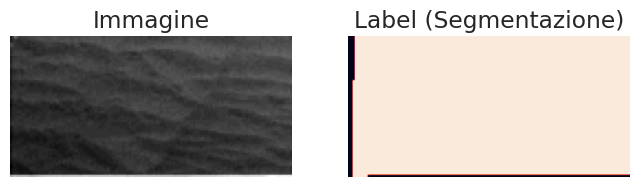

Img 2


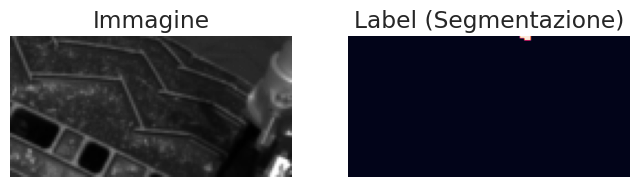

Img 3


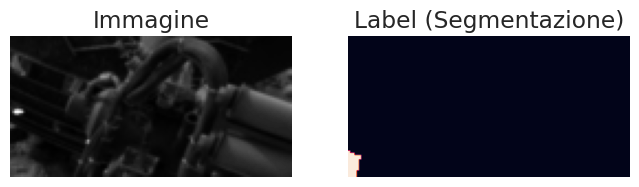

Img 4


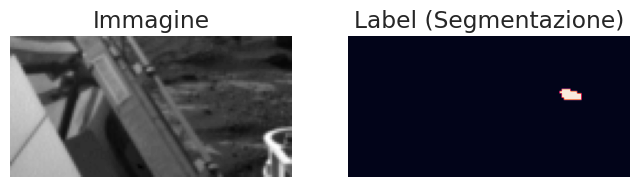

Img 5


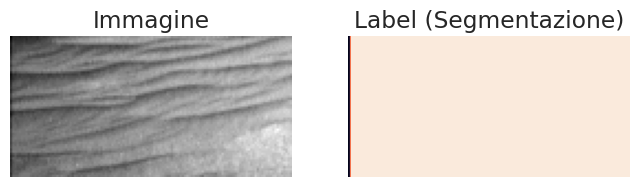

Img 6


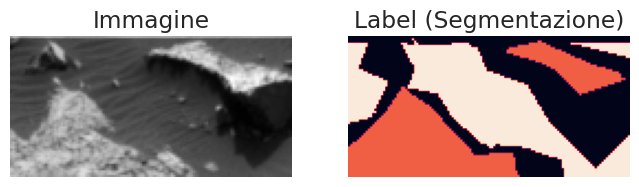

Img 7


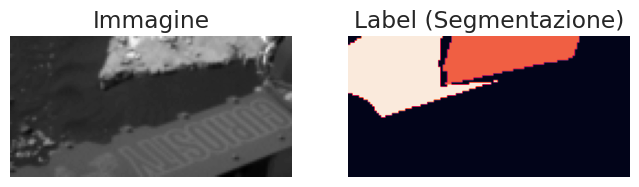

Img 8


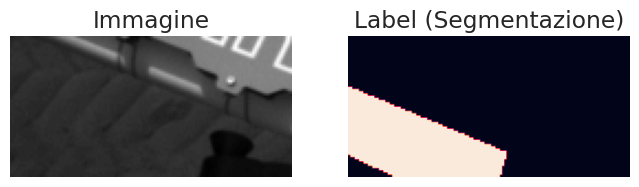

Img 9


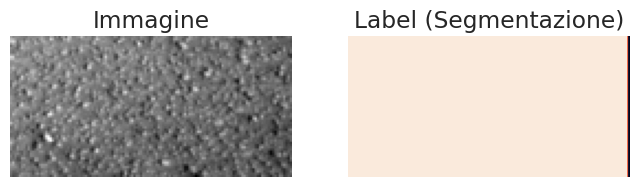

Img 10


In [6]:
import matplotlib.pyplot as plt

# Supponiamo che X_train contenga le immagini e y_train le etichette di segmentazione
for i, (img, label) in enumerate(zip(X_train, y_train)):
    plt.figure(figsize=(8, 4))
    
    print("Img " + str(i))
    
    # Immagine originale
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
    plt.title("Immagine")
    plt.axis('off')
    
    # Label di segmentazione
    plt.subplot(1, 2, 2)
    plt.imshow(label)
    plt.title("Label (Segmentazione)")
    plt.axis('off')
    
    plt.show()

    
    # Limita il numero di immagini mostrate, ad esempio a 10
    if i >= 10:
        break


In [7]:
# Flatten y_train to aggregate pixel counts across all images
all_pixels = np.concatenate([y.flatten() for y in y_train])

# Count the occurrences of each class
unique_classes, counts = np.unique(all_pixels, return_counts=True)

# Calculate the total number of pixels
total_pixels = all_pixels.size

# Calculate the percentage of each class
class_percentages = {cls: (count / total_pixels) * 100 for cls, count in zip(unique_classes, counts)}

# Print results
print("Class percentages:")
for cls, percentage in class_percentages.items():
    print(f"Class {cls}: {percentage:.2f}%")


Class percentages:
Class 0.0: 24.31%
Class 1.0: 33.90%
Class 2.0: 23.28%
Class 3.0: 18.38%
Class 4.0: 0.13%


In [8]:
def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

La classe 4 è presente in 63 immagini.
Img 31


Img 56


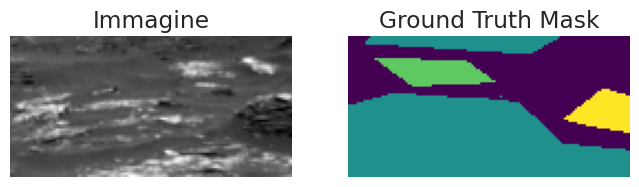

Img 57


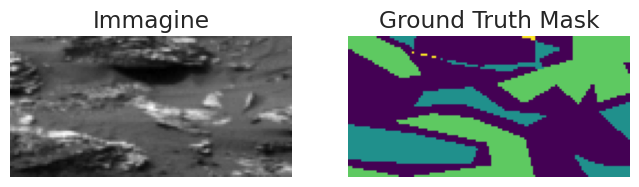

Img 140


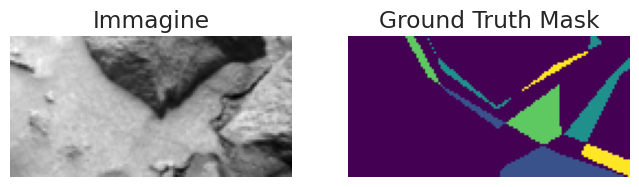

Img 145


Img 158


Img 162


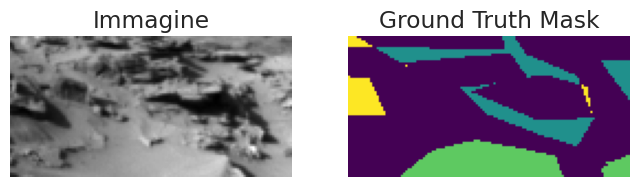

Img 241


Img 326


Img 382


Img 406


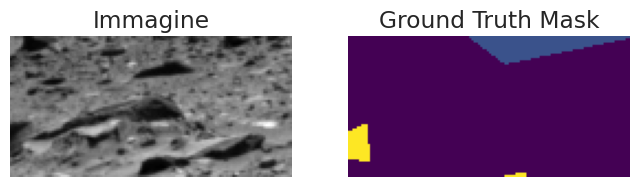

Img 443


Img 470


Img 475


Img 572


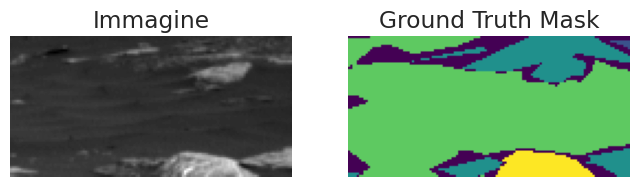

Img 614


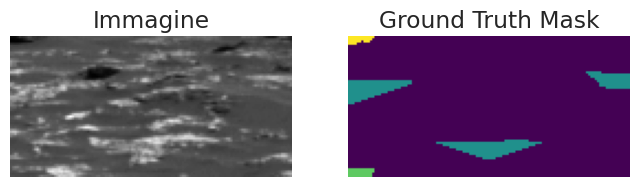

Img 728


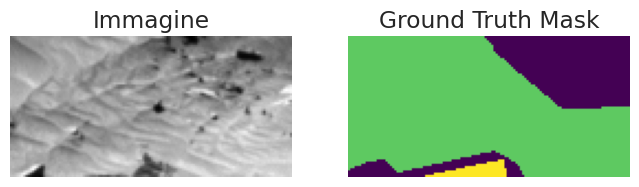

Img 737


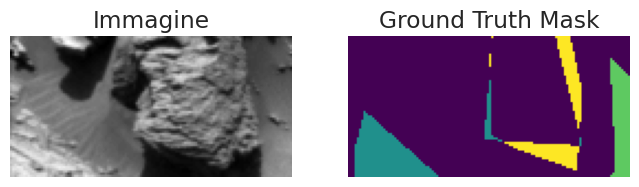

Img 739


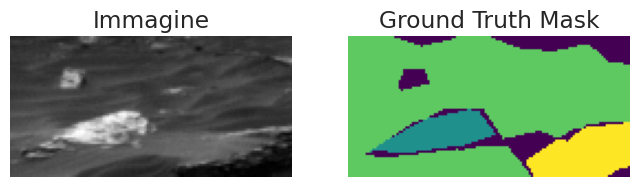

Img 813


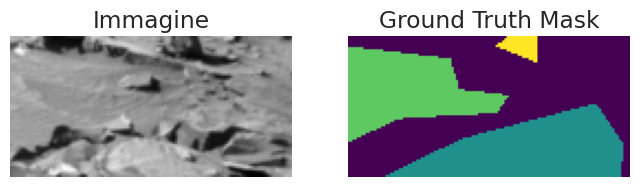

Img 832


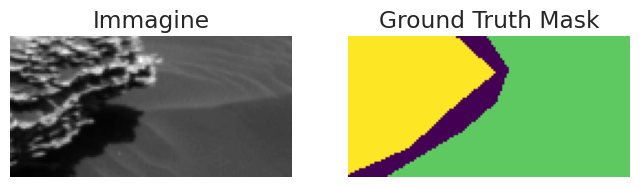

Img 849


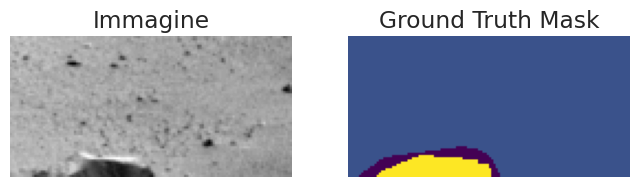

Img 856


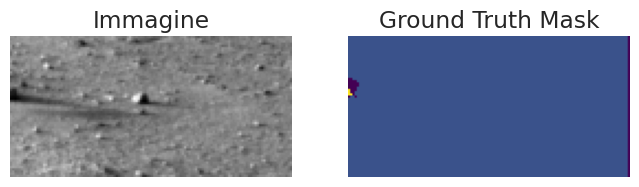

Img 872


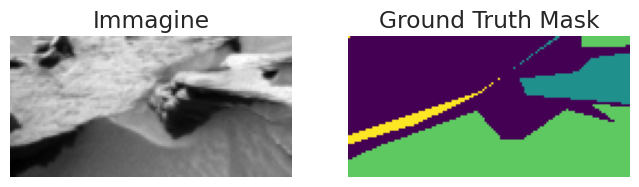

Img 922


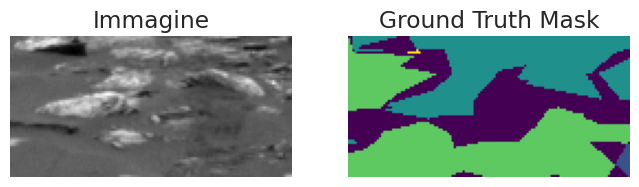

Img 985


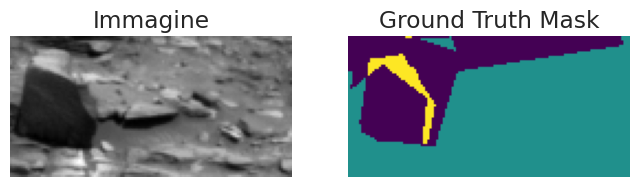

Img 1026


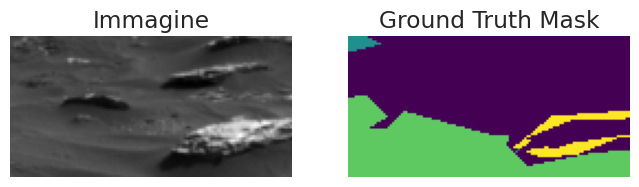

Img 1030


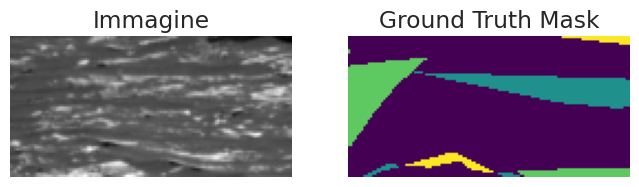

Img 1125


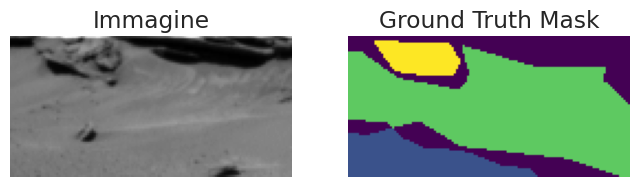

Img 1162


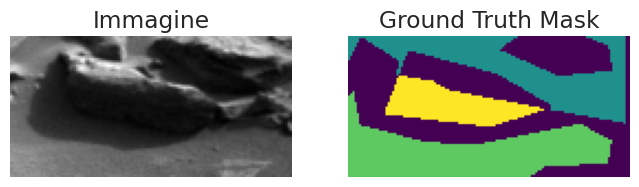

Img 1168


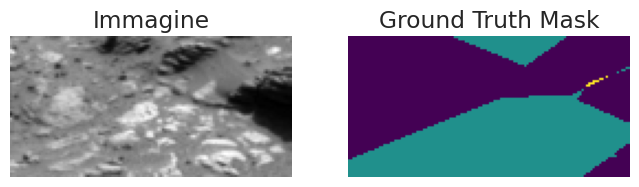

Img 1169


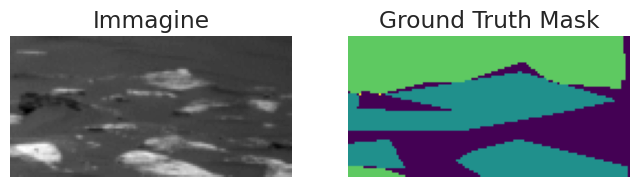

Img 1182


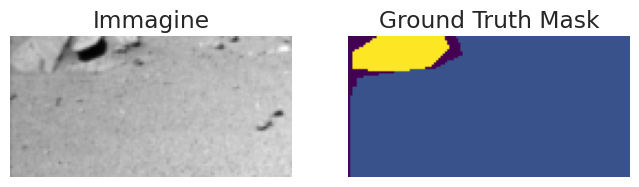

Img 1266


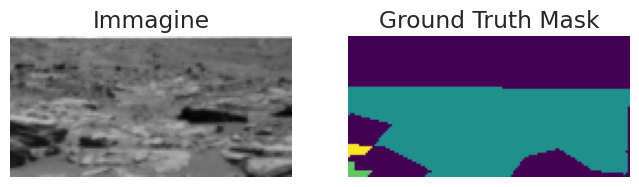

Img 1337


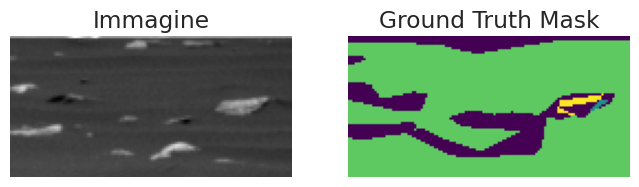

Img 1443


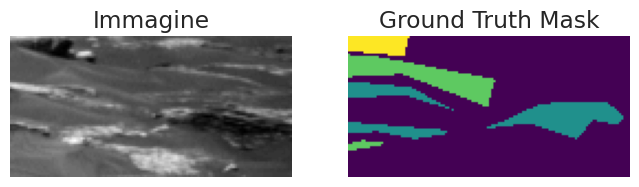

Img 1456


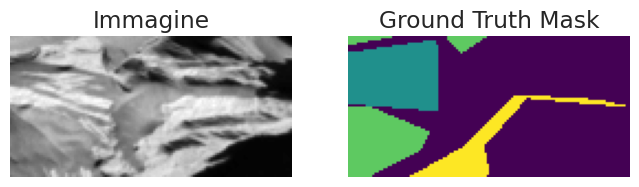

Img 1475


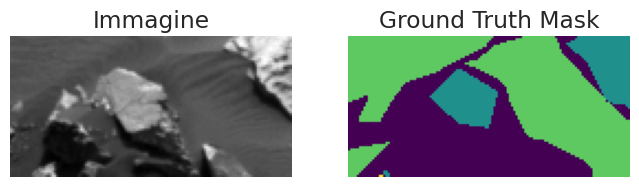

Img 1491


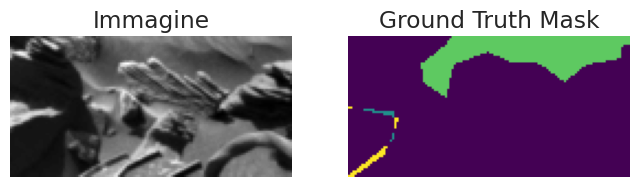

Img 1526


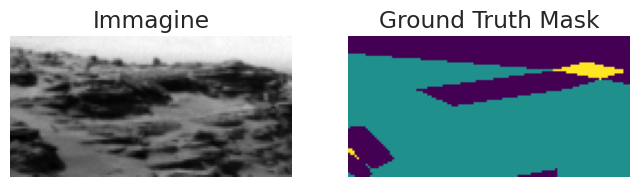

Img 1527


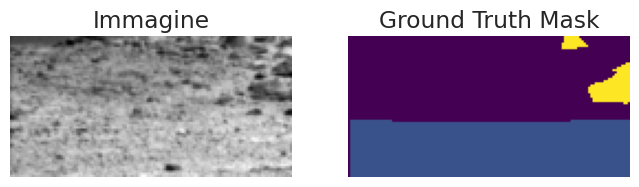

Img 1544


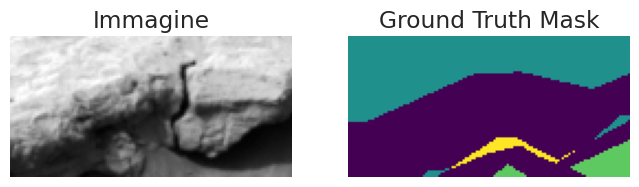

Img 1576


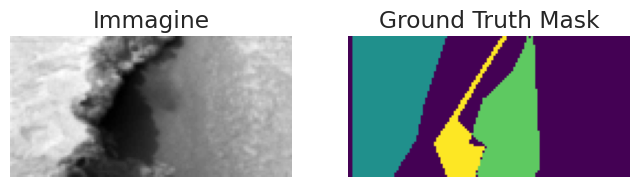

Img 1633


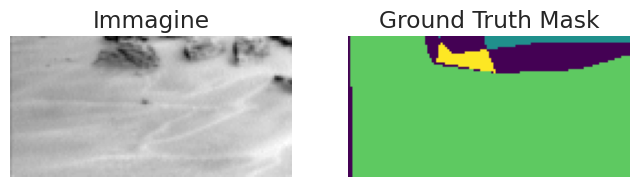

Img 1684


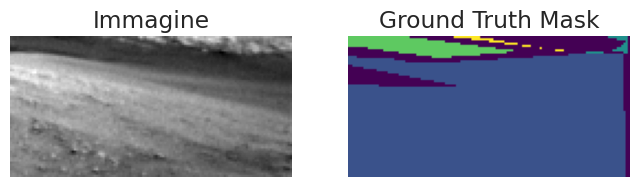

Img 1781


Img 1792


Img 1883


Img 1919


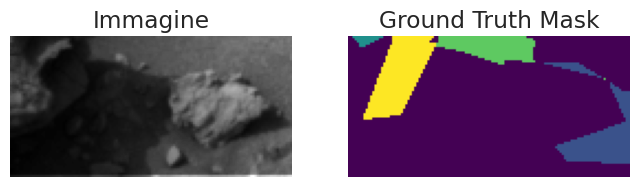

Img 2014


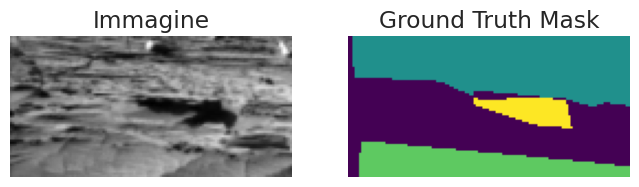

Img 2055


Img 2086


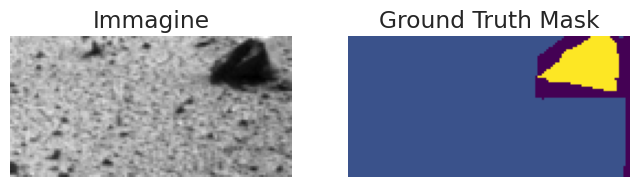

Img 2102


Img 2111


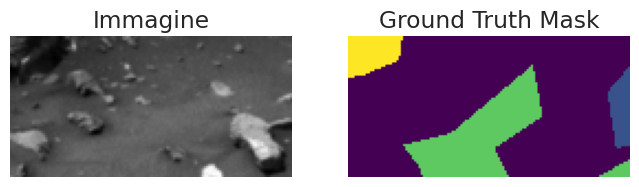

Img 2156


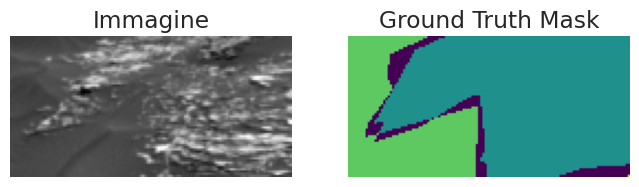

Img 2193


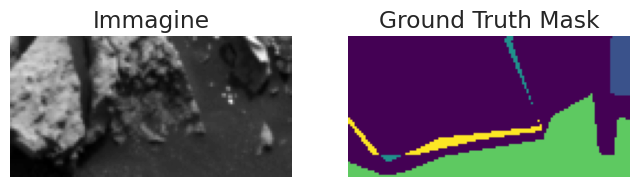

Img 2199


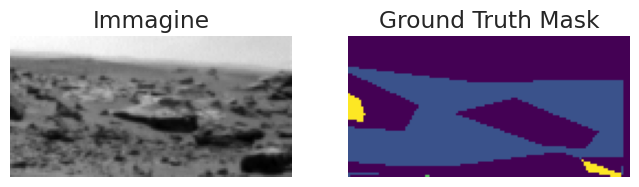

Img 2253


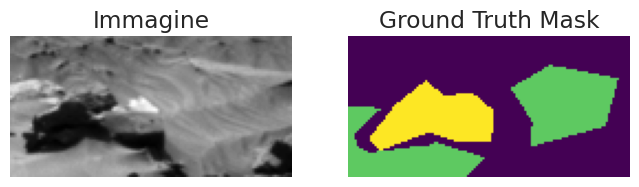

Img 2331


Img 2351


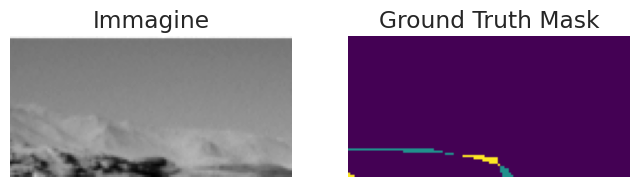

Img 2412


Img 2417


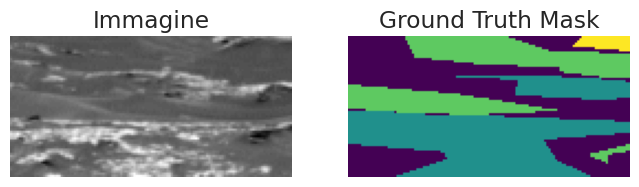

Img 2498


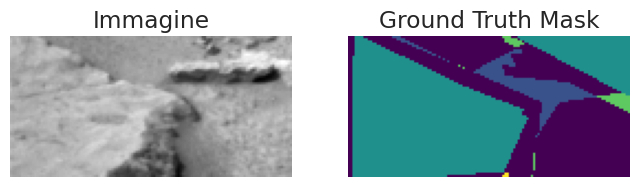

In [9]:
target_class = 4
num_images_with_class = sum(target_class in np.unique(y) for y in y_train)
print(f"La classe {target_class} è presente in {num_images_with_class} immagini.")


# Trova gli indici delle immagini che contengono la classe target
indices_with_class = [idx for idx, y in enumerate(y_train) if target_class in np.unique(y)]


for idx in indices_with_class:
    plt.figure(figsize=(8, 4))
    
    print("Img " + str(idx))
    
    # Immagine originale
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title("Immagine")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    colormap = plt.cm.viridis(np.linspace(0, 1, 5))
    colored_label = apply_colormap(y_train[idx], colormap)
    plt.imshow(colored_label)
    plt.title("Ground Truth Mask")
    plt.axis('off')
    
    plt.show()


In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed
)

In [11]:
X_train, X_test2, y_train, y_test2 = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)

In [12]:
category_map = {
        0: 0,  # unlabelled
        1: 1,
        2: 2,
        3: 3,
        4: 4
}
    
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(int(label))

In [13]:
import tensorflow_addons as tfa

@tf.function
def random_rotate_translate(image, label, seed=None):
    """Apply random rotation and translation."""
    
    flip_prob = tf.random.uniform([])
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )

    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    
    # Random rotation
    #angle = tf.random.uniform([], minval=-1, maxval=1, seed=seed)  # Rotation range in radians
    #image = tfa.image.rotate(image, angle)
    #label = tfa.image.rotate(label, angle)

    # Random translation
    #translations = tf.random.uniform([2], minval=-10, maxval=10, seed=seed)  # Translation in pixels
    #image = tfa.image.translate(image, translations)
    #label = tfa.image.translate(label, translations)

    return image, label


In [14]:
def plot_images_from_dataset(dataset, num_images=5):
    """
    Plots a few images with their labels from a TensorFlow dataset.
    
    Args:
        dataset: A TensorFlow dataset containing images and labels.
        num_images: Number of images to display.
    """
    # Iterate through the dataset to extract images and labels
    for i, (image, label) in enumerate(dataset.take(num_images)):
        # Immagine originale
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title("Immagine")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        colormap = plt.cm.viridis(np.linspace(0, 1, 5))
        colored_label = apply_colormap(tf.math.argmax(label, axis=-1), colormap)
        plt.imshow(colored_label)
        plt.title("Ground Truth Mask")
        plt.axis('off')

    plt.show()

In [15]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    mask4 = [idx for idx in range(len(images)) if 4 in np.unique(labels[idx])]

    images = tf.expand_dims(images, axis=-1)  # Ensure images have a single channel (grayscale or RGB)
    
    # One-hot encode the labels and convert to uint8
    labels = tf.cast(labels, tf.uint8)  # Convert labels to uint8
    labels = tf.keras.backend.one_hot(labels, NUM_CLASSES)  # One-hot encoding the labels

    # Trova gli indici delle immagini che contengono la classe target
    class4_dataset = tf.data.Dataset.from_tensor_slices((tf.gather(images, mask4), tf.gather(labels, mask4)))
    class4_dataset = class4_dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),  # You can define apply_category_mapping based on your needs
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Create dataset from images and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping if needed (you can modify this function as necessary)
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),  # You can define apply_category_mapping based on your needs
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset2 = dataset.map(
            lambda x, y: random_rotate_translate(x, y, seed=seed),  # Define random_flip for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.concatenate(dataset2)


    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [16]:
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)


val_dataset = make_dataset(
    X_val, y_val,
    batch_size=25,
    shuffle=True,
    seed=seed
)


test_dataset = make_dataset(
    X_test2, y_test2,
    batch_size=25,
    shuffle=True,
    seed=seed
)

In [17]:
# Print the shape of a single batch from the train_dataset
for img_batch, lbl_batch in train_dataset.take(1):  # Taking the first batch
    print("Image batch shape:", img_batch.shape)
    print("Label batch shape:", lbl_batch.shape)

Image batch shape: (256, 64, 128, 1)
Label batch shape: (256, 64, 128, 5)


In [18]:
def unet_block(input_tensor, 
               filters, 
               kernel_size=3, 
               activation='relu', 
               dropout_rate=0,
               stack=1, 
               name=''):
    
    # Initialize the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters=filters, 
                        kernel_size=kernel_size, 
                        strides=(1, 1),
                        padding='same', 
                        kernel_initializer='HeNormal', 
                        name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation=activation, 
                            name=name + 'activation' + str(i + 1))(x)
        if dropout_rate > 0:
            x = tfkl.Dropout(dropout_rate, name=name + 'dropout')(x)
    
    # Return the transformed tensor
    return x

In [19]:
def upsampling_block(input_tensor, 
                     down_block,
                     filters, 
                     kernel_size=2, 
                     activation='relu', 
                     kernel_initializer='HeNormal', 
                     stack=1, 
                     name=''):

    # Initialize the Input Tensor
    x = input_tensor

    # Apply a sequence of Conv2DTranspose and Concatenate for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2DTranspose(filters=filters, 
                                 kernel_size=kernel_size, 
                                 strides=(2, 2), 
                                 padding='same', 
                                 kernel_initializer=kernel_initializer, 
                                 name=name + 'conv_transpose'+ str(i + 1))(x)
        x = tfkl.Add()([x, down_block])

    return x

In [20]:
# Squeeze-and-Excitation Block (SENet, 2017)

def se_block(x, filters,
                kernel_size=3,
                padding='same',
                downsample=True,
                activation='relu',
                stack=2,
                name='senet'):

    for s in range(stack):
        # Squeeze-and-Excitation (SE) Module
        channels = x.shape[-1]

        # Squeeze step
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_squeeze_{s}')(x)

        # Excitation step (Compress the information: reduce the number channels)
        se = tfkl.Dense(channels // 16, activation=activation, name=f'{name}_dense1_{s}')(se)
        se = tfkl.Dense(channels, activation='sigmoid', name=f'{name}_dense2_{s}')(se)

        # Scaling the output with SE activation
        se = tfkl.Reshape((1, 1, channels))(se)
        x = tfkl.Multiply(name=f'{name}_scale_{s}')([x, se])

    # Optional Downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [21]:
def unet_gating_signal(input_tensor, batch_norm=True, name=''):
    input_shape = input_tensor.shape
    x = tfkl.Conv2D(filters=input_shape[3] * 1, 
                    kernel_size=(1, 1), 
                    strides=(1, 1), 
                    padding='same',
                    kernel_initializer='HeNormal', 
                    name=name + '_conv')(input_tensor)
    if batch_norm:
        x = tfkl.BatchNormalization(name=name + '_bn')(x)
    x = tfkl.Activation(activation='relu', name=name + '_act')(x)
    return x

def attention_gate_block(x, g, inter_shape, batch_norm=True, dropout_rate=0, name=''):
    x_shape = x.shape
    g_shape = g.shape

    theta_x = tfkl.Conv2D(inter_shape, 
                          kernel_size=(2, 2), 
                          strides=(2, 2), 
                          padding='same', 
                          name='xl' + name)(x)
    theta_x_shape = theta_x.shape

    phi_g = tfkl.Conv2D(inter_shape, 
                        kernel_size=(1, 1), 
                        strides=(1, 1),
                        padding='same')(g)
    upsample_g = tfkl.Conv2DTranspose(inter_shape, 
                                      kernel_size=(3, 3), 
                                      strides=(theta_x_shape[1] // g_shape[1], 
                                               theta_x_shape[2] // g_shape[2]), 
                                      padding='same', 
                                      name='g_up' + name)(phi_g) 

    concat_xg = tfkl.Add()([theta_x, upsample_g])
    act_xg = tfkl.Activation(activation='relu')(concat_xg)

    psi = tfkl.Conv2D(filters=1, 
                      kernel_size=(1, 1), 
                      strides=(1, 1),
                      padding='same', 
                      name='psi'+ name)(act_xg)
    sigmoid_xg = tfkl.Activation(activation='sigmoid')(psi)

    sigmoid_xg_shape = sigmoid_xg.shape
    upsample_psi = tfkl.UpSampling2D(size=(x_shape[1] // sigmoid_xg_shape[1], 
                                           x_shape[2] // sigmoid_xg_shape[2]))(sigmoid_xg)

    y = tfkl.Multiply(name='q_attn' + name)([x, upsample_psi])
    result = tfkl.Conv2D(filters=x_shape[3], 
                         kernel_size=(1, 1), 
                         strides=(1, 1),
                         padding='same', 
                         name='q_attn_conv' + name)(y)
    # Optional Layer
    if batch_norm:
        result = tfkl.BatchNormalization(name='q_attn_bn' + name)(result)

    if dropout_rate > 0:
        result = tfkl.Dropout(dropout_rate, name=name + 'dropout')(result)

    return result

In [22]:
def attn_upsampling_block(input_tensor, 
                     concat_block,
                     filters=64, 
                     kernel_size=3, 
                     padding='same',
                     activation='relu', 
                     kernel_initializer='HeNormal', 
                     name=''):

    # Initialize the Input Tensor
    x = input_tensor

    # Apply a sequence of Conv2DTranspose and Concatenate for the specified number of stacks
    x = tfkl.Conv2DTranspose(filters=filters, 
                             kernel_size=kernel_size, 
                             strides=(2, 2), 
                             padding=padding, 
                             activation=activation,
                             kernel_initializer=kernel_initializer, 
                             name=name + 'conv_transpose')(x)
    x = tfkl.Concatenate(name=name + 'concat')([concat_block, x])

    return x

In [23]:
import keras_cv

def augmentation_layer():
    return tf.keras.Sequential([
        tf.keras.layers.RandomBrightness(0.1),
        keras_cv.layers.RandomContrast([0, 255], 0.2),
        keras_cv.layers.RandomGaussianBlur(2, 1),
        tf.keras.layers.GaussianNoise(0.05)
    ])
    
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    input_layer = augmentation_layer()(input_layer)

    # Downsampling path
    
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, dropout_rate=0, name='down_block3_')  # Additional downsampling block
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 128, dropout_rate=0, name='down_block4_')  # Another additional downsampling block
    d4 = tfkl.MaxPooling2D()(down_block_4)

    #down_block_5 = unet_block(d4, 256, dropout_rate=0, name='down_block5_')  # Another additional downsampling block
    #d5 = tfkl.MaxPooling2D()(down_block_5)

    #down_block_6 = unet_block(d5, 256, dropout_rate=0, name='down_block6_')  # Another additional downsampling block
    #d6 = tfkl.MaxPooling2D()(down_block_6)

    # Bottleneck
    bottleneck = unet_block(d4, 256, name='bottleneck')

    # Upsampling path

    #g6 = unet_gating_signal(bottleneck, batch_norm=True, name='g6')
    #attn6 = attention_gate_block(down_block_6, g6, 512, dropout_rate=0, name='_6')
    #u6 = attn_upsampling_block(bottleneck, attn6, name='up_block6_')

    #g5 = unet_gating_signal(u6, batch_norm=True, name='g5')
    #attn5 = attention_gate_block(down_block_5, g5, 256, dropout_rate=0, name='_5')
    #u5 = attn_upsampling_block(u6, attn5, name='up_block5_')

    g4 = unet_gating_signal(bottleneck, batch_norm=True, name='g4')
    attn4 = attention_gate_block(down_block_4, g4, 256, dropout_rate=0, name='_4')
    u4 = attn_upsampling_block(bottleneck, attn4, name='up_block4_')

    g3 = unet_gating_signal(u4, batch_norm=True, name='g3')
    attn3 = attention_gate_block(down_block_3, g3, 128, dropout_rate=0, name='_3')
    u3 = attn_upsampling_block(u4, attn3, name='up_block3_')

    g2 = unet_gating_signal(u3, batch_norm=True, name='g2')
    attn2 = attention_gate_block(down_block_2, g2, 64, dropout_rate=0, name='_2')
    u2 = attn_upsampling_block(u3, attn2, name='up_block2_')

    u1 = attn_upsampling_block(u2, down_block_1, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, 
                               kernel_size=1, 
                               strides=(1, 1), 
                               padding='same', 
                               activation="softmax", 
                               name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [24]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = get_unet_model()
    model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_5CLONE │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv1   │ (None, 64, 128,   │        640 │ keras_tensor_5CL… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn1     │ (None, 64, 128,   │        256 │ down_block1_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ down_block1_bn1[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ down_block1_acti… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_conv1   │ (None, 32, 64,    │     36,928 │ max_pooling2d[2]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_bn1     │ (None, 32, 64,    │        256 │ down_block2_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_activa… │ (None, 32, 64,    │          0 │ down_block2_bn1[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ down_block2_acti… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block3_conv1   │ (None, 16, 32,    │     73,856 │ max_pooling2d_1[… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block3_bn1     │ (None, 16, 32,    │        512 │ down_block3_conv… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block3_activa… │ (None, 16, 32,    │          0 │ down_block3_bn1[… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 16,     │          0 │ down_block3_acti… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block4_conv1   │ (None, 8, 16,     │    147,584 │ max_pooling2d_2[… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block4_bn1     │ (None, 8, 16,     │        512 │ down_block4_conv… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block4_activa… │ (None, 8, 16,     │          0 │ down_block4_bn1[… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 8, 128) │          0 │ down_block4_acti

 Total params: 2,272,264 (8.67 MB)

 Trainable params: 2,269,064 (8.66 MB)

 Non-trainable params: 3,200 (12.50 KB)

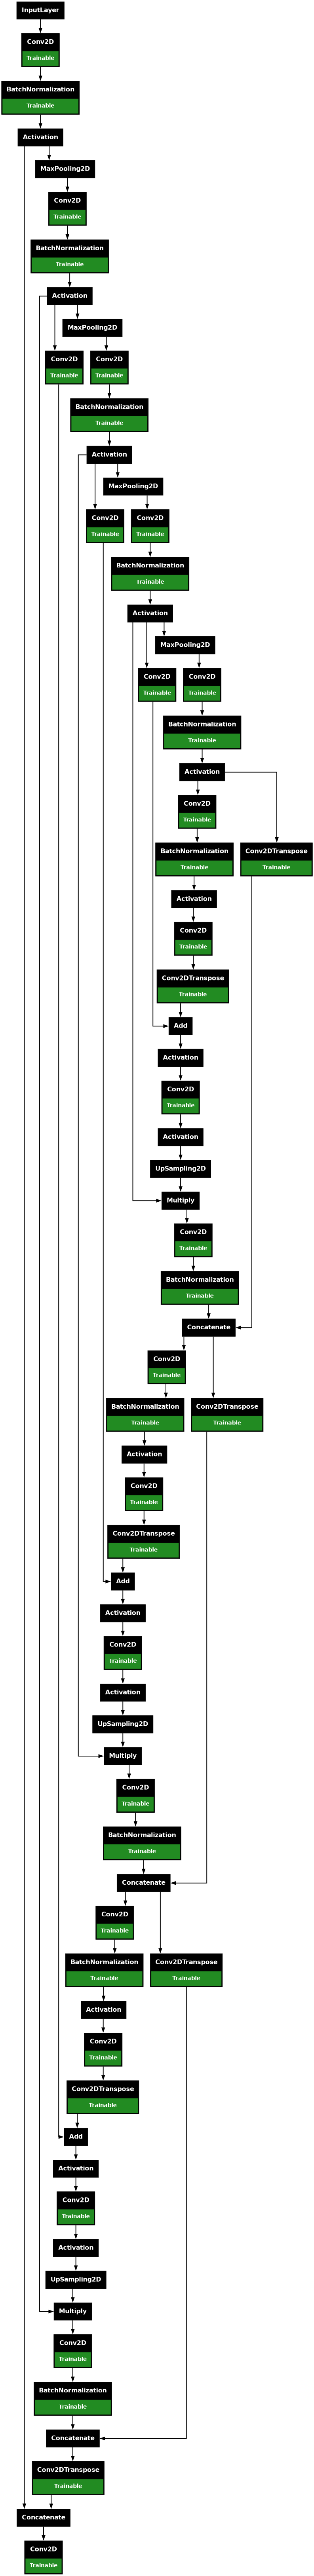

In [25]:
tfk.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [31]:
import random
        
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.math.argmax(y_true, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5):
        super().__init__()
        self.images = images
        self.labels = labels
        self.frequency = frequency

    def apply_colormap(self, label, colormap=None):
        """
        Apply the colormap to a label.
        """
        # Ensure label is 2D
        label = np.squeeze(label)
    
        if colormap is None:
            num_classes = len(np.unique(label))
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))
    
        # Apply the colormap
        colored = colormap[label.astype(int)]
    
        return colored

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            idx = random.randint(0, len(self.images))
            image = self.images[idx]
            label = self.labels[idx]
            
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = self.apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = self.apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [32]:
import tensorflow.keras.backend as K

total_percentage = sum(class_percentages.values())
class_weights = {cls: total_percentage / percentage for cls, percentage in class_percentages.items()}

# Convert class_weights to a tensor (use in TensorFlow/Keras)
class_weights_tensor = tf.constant([class_weights[c] for c in sorted(class_weights.keys())], dtype=tf.float32)
class_weights_tensor = class_weights_tensor / tf.norm(class_weights_tensor)

def compute_distance_map(y_true):
    """
    Approximate the distance map using TensorFlow operations.
    This applies a convolution-based smoothing filter.
    """
    # Ensure y_true is one-hot encoded and float
    y_true = tf.cast(y_true, tf.float32)

    # Define a simple Gaussian kernel for smoothing
    def gaussian_kernel(size: int, sigma: float):
        """
        Create a 2D Gaussian kernel using TensorFlow.
        """
        x = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
        y = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
        x, y = tf.meshgrid(x, y)
        kernel = tf.exp(-(x**2 + y**2) / (2.0 * sigma**2))
        kernel = kernel / tf.reduce_sum(kernel)
        return kernel

    kernel_size = 15
    sigma = 5.0
    gaussian = gaussian_kernel(kernel_size, sigma)
    gaussian = gaussian[:, :, tf.newaxis, tf.newaxis]

    distances = []
    for c in range(y_true.shape[-1]):
        class_map = y_true[..., c: c + 1]  # Extract single class channel
        # Apply Gaussian smoothing using 2D convolution
        smoothed = tf.nn.conv2d(
            class_map[tf.newaxis],  # Add batch dimension
            gaussian,
            strides=[1, 1, 1, 1],
            padding="SAME"
        )[0]  # Remove batch dimension
        distances.append(smoothed)

    return tf.stack(distances, axis=-1)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Ensure predictions are within valid probability range
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Compute cross-entropy
    cross_entropy = -y_true * tf.math.log(y_pred)
    
    # Compute the focal weight
    focal_weight = alpha * tf.pow(1 - y_pred, gamma)
    
    # Apply the focal weight to the cross-entropy
    loss = focal_weight * cross_entropy
    
    # Take the mean over all classes
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

def weighted_categorical_crossentropy(y_true, y_pred):
    """
    Weighted Categorical Cross-Entropy Loss
    """
    # Clip the predictions to avoid log(0) errors
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Compute categorical cross-entropy
    cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    
    # Apply class weights: element-wise multiplication
    # class_weights should be broadcastable to match the shape of y_true
    weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)  # Weighting for each sample in the batch
    
    # Compute the weighted loss by multiplying cross-entropy by the weights
    weighted_cross_entropy = weights * cross_entropy
    
    # Return the mean of the weighted loss over the batch
    return tf.reduce_mean(weighted_cross_entropy)

    
@tf.function
def dice_loss(y_pred, y_true):
    
    epsilon = 1e-6  # Per evitare divisioni per zero
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=(0, 1, 2))
    pred_sum = tf.reduce_sum(y_pred**2, axis=(0, 1, 2))
    true_sum = tf.reduce_sum(y_true**2, axis=(0, 1, 2))

    dice = (2.0 * intersection + epsilon) / (pred_sum + true_sum + epsilon)
        
    loss = 1.0 - tf.reduce_mean(dice)
    return loss


def boundary_loss(y_true, y_pred):
    """
    Boundary Loss: Penalizes differences along the boundary.
    """
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Compute distance map
    distance_map = compute_distance_map(y_true)
    distance_map = tf.squeeze(distance_map, axis=3)
    
    # Compute boundary loss as the L2 loss between distance map and predicted boundaries
    boundary_diff = distance_map * (y_true - y_pred)
    boundary_loss_value = tf.reduce_mean(tf.square(boundary_diff))
    return boundary_loss_value
    
@tf.function
def combined_loss(y_true, y_pred):
    """
    Combined Loss: Weighted Categorical Cross-Entropy + Dice Loss + Boundary Loss
    """
    loss_ce = weighted_categorical_crossentropy(y_true, y_pred)
    loss_focal = focal_loss(y_true, y_pred)
    loss_dice = dice_loss(y_true, y_pred)
    
    #loss_boundary = boundary_loss(y_true, y_pred)
    # Aggiungi la stampa dei valori
    #tf.print("CE Loss:", loss_ce)
    #tf.print("Focal Loss:", loss_focal)
    #tf.print("Dice Loss:", loss_dice)
    #tf.print("Boundary Loss:", loss_boundary *10)

    # Combine all loss terms with weights
    #return loss_focal + loss_dice + 10 * loss_boundary
    return loss_ce + 2 * loss_focal + loss_dice


# Compile the model with the custom combined loss
print("Compiling model...")
with strategy.scope():
    model.compile(
        loss=combined_loss,
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=[
            MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0]),
            tf.keras.metrics.IoU(NUM_CLASSES, [1], name="class1", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [2], name="class2", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [3], name="class3", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [4], name="class4", sparse_y_true=False, sparse_y_pred=False)
        ]
        #class_weights=class_weights_tensor
    )
print("Model compiled!")


Compiling model...
Model compiled!


In [33]:
# Setup callbacks
with strategy.scope():
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_iou',
        mode='max',
        patience=PATIENCE,
        restore_best_weights=True
    )
    
    viz_callback = VizCallback(X_val, y_val)

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - class1: 0.7652 - class2: 0.6076 - class3: 0.6428 - class4: 0.0570 - loss: 0.5218 - mean_iou: 0.4776

W0000 00:00:1733779475.437055      23 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 1 } dim { size: 64 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 1 } dim { size: 64 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12030" } environment { key: "cudnn" value: "8906" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multipro

15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 778ms/step - class1: 0.7651 - class2: 0.6085 - class3: 0.6442 - class4: 0.0579 - loss: 0.5211 - mean_iou: 0.4782 - val_class1: 0.6806 - val_class2: 0.4663 - val_class3: 0.6318 - val_class4: 0.0000e+00 - val_loss: 0.6574 - val_mean_iou: 0.4095
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 447ms/step - class1: 0.7811 - class2: 0.6296 - class3: 0.6587 - class4: 0.0788 - loss: 0.5061 - mean_iou: 0.4932 - val_class1: 0.6879 - val_class2: 0.4679 - val_class3: 0.6101 - val_class4: 0.0236 - val_loss: 0.6780 - val_mean_iou: 0.4121
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 447ms/step - class1: 0.7874 - class2: 0.6362 - class3: 0.6600 - class4: 0.0779 - loss: 0.4988 - mean_iou: 0.4961 - val_class1: 0.6668 - val_class2: 0.4778 - val_class3: 0.5945 - val_class4: 0.0319 - val_loss: 0.6807 - val_mean_iou: 0.4146
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 443ms/step - class1: 0.7980 - class2: 0.6387 - class3: 0.6687 - class4: 0.0817 - loss: 0.4912 - mean_iou: 0.5005 - val_

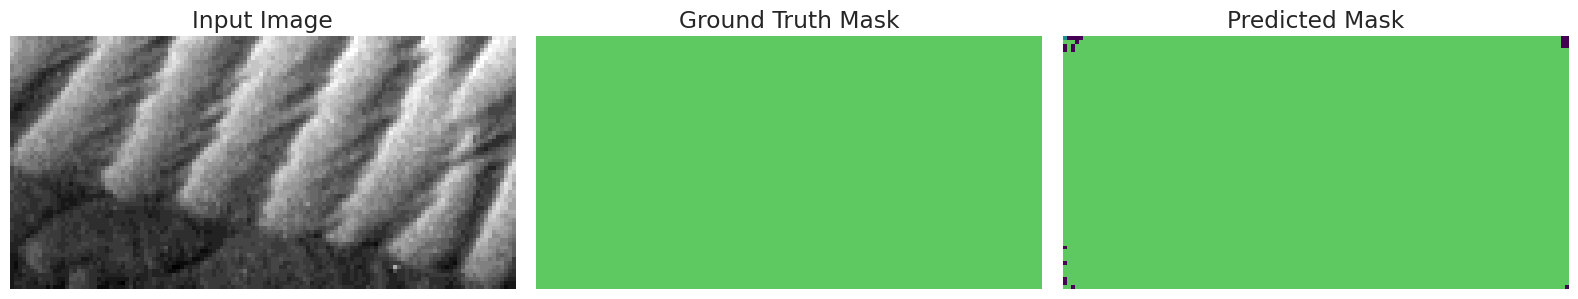

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 484ms/step - class1: 0.8017 - class2: 0.6459 - class3: 0.6668 - class4: 0.1019 - loss: 0.4828 - mean_iou: 0.5078 - val_class1: 0.6967 - val_class2: 0.5202 - val_class3: 0.6017 - val_class4: 0.0000e+00 - val_loss: 0.6531 - val_mean_iou: 0.4224
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 426ms/step - class1: 0.7919 - class2: 0.6358 - class3: 0.6604 - class4: 0.1003 - loss: 0.4923 - mean_iou: 0.5013 - val_class1: 0.6960 - val_class2: 0.4676 - val_class3: 0.6127 - val_class4: 0.0339 - val_loss: 0.6620 - val_mean_iou: 0.4173
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - class1: 0.7931 - class2: 0.6406 - class3: 0.6584 - class4: 0.1026 - loss: 0.4926 - mean_iou: 0.5034 - val_class1: 0.7014 - val_class2: 0.5135 - val_class3: 0.6757 - val_class4: 0.0044 - val_loss: 0.6340 - val_mean_iou: 0.4271
Epoch 9/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 420ms/step - class1: 0.7882 - class2: 0.6335 - class3: 0.6595 - class4: 0.0740 - loss: 0.5024 - mean_iou: 0.4951 - val_c

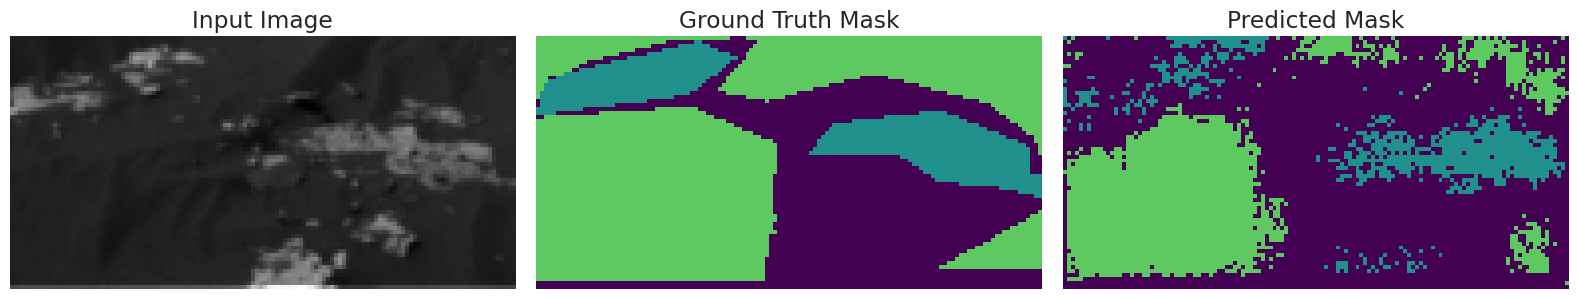

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 530ms/step - class1: 0.7914 - class2: 0.6375 - class3: 0.6657 - class4: 0.0931 - loss: 0.4909 - mean_iou: 0.5012 - val_class1: 0.6630 - val_class2: 0.5233 - val_class3: 0.6421 - val_class4: 0.0000e+00 - val_loss: 0.6623 - val_mean_iou: 0.4265
Epoch 12/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 433ms/step - class1: 0.7968 - class2: 0.6327 - class3: 0.6714 - class4: 0.0966 - loss: 0.4933 - mean_iou: 0.5028 - val_class1: 0.7054 - val_class2: 0.5199 - val_class3: 0.6490 - val_class4: 0.0309 - val_loss: 0.6286 - val_mean_iou: 0.4347
Epoch 13/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - class1: 0.7963 - class2: 0.6397 - class3: 0.6629 - class4: 0.1320 - loss: 0.4790 - mean_iou: 0.5110 - val_class1: 0.6901 - val_class2: 0.5062 - val_class3: 0.6300 - val_class4: 0.0000e+00 - val_loss: 0.6266 - val_mean_iou: 0.4249
Epoch 14/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 434ms/step - class1: 0.8025 - class2: 0.6417 - class3: 0.6626 - class4: 0.1306 - loss: 0.4788 - mean_iou: 0.5124 

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 476ms/step - class1: 0.8058 - class2: 0.6465 - class3: 0.6679 - class4: 0.1356 - loss: 0.4767 - mean_iou: 0.5150 - val_class1: 0.6987 - val_class2: 0.5132 - val_class3: 0.6555 - val_class4: 0.0208 - val_loss: 0.6399 - val_mean_iou: 0.4418
Epoch 17/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 428ms/step - class1: 0.8015 - class2: 0.6414 - class3: 0.6665 - class4: 0.1267 - loss: 0.4764 - mean_iou: 0.5109 - val_class1: 0.6686 - val_class2: 0.4928 - val_class3: 0.6200 - val_class4: 0.0059 - val_loss: 0.6647 - val_mean_iou: 0.4112
Epoch 18/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 433ms/step - class1: 0.8038 - class2: 0.6437 - class3: 0.6634 - class4: 0.1235 - loss: 0.4807 - mean_iou: 0.5117 - val_class1: 0.6669 - val_class2: 0.5115 - val_class3: 0.6484 - val_class4: 0.0354 - val_loss: 0.6522 - val_mean_iou: 0.4316
Epoch 19/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - class1: 0.7951 - class2: 0.6399 - class3: 0.6593 - class4: 0.1274 - loss: 0.4870 - mean_iou: 0.5089 - val_cl

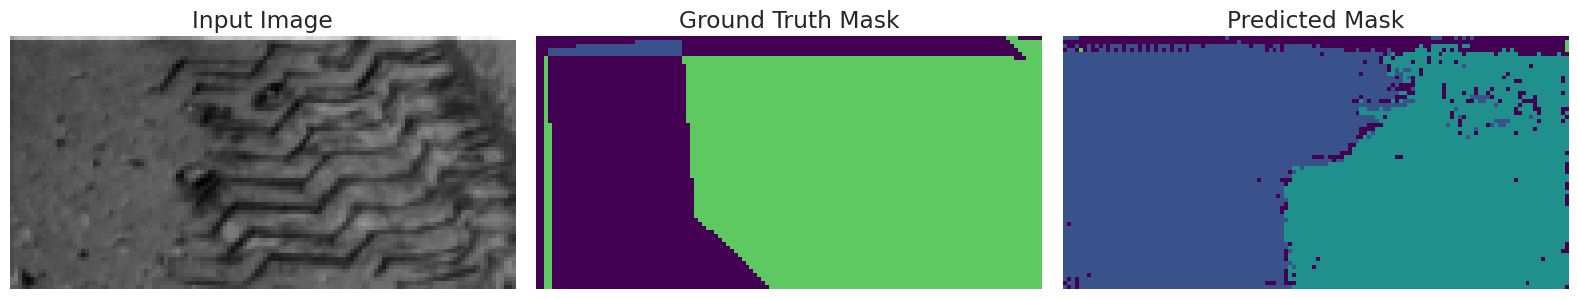

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 466ms/step - class1: 0.8005 - class2: 0.6442 - class3: 0.6608 - class4: 0.1471 - loss: 0.4729 - mean_iou: 0.5136 - val_class1: 0.6763 - val_class2: 0.5450 - val_class3: 0.6881 - val_class4: 0.0000e+00 - val_loss: 0.6378 - val_mean_iou: 0.4382
Epoch 22/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 430ms/step - class1: 0.7948 - class2: 0.6424 - class3: 0.6627 - class4: 0.1487 - loss: 0.4738 - mean_iou: 0.5173 - val_class1: 0.7095 - val_class2: 0.4699 - val_class3: 0.6331 - val_class4: 0.0000e+00 - val_loss: 0.6606 - val_mean_iou: 0.4140
Epoch 23/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - class1: 0.8032 - class2: 0.6522 - class3: 0.6685 - class4: 0.1623 - loss: 0.4626 - mean_iou: 0.5252 - val_class1: 0.7022 - val_class2: 0.4977 - val_class3: 0.6510 - val_class4: 0.0047 - val_loss: 0.6324 - val_mean_iou: 0.4320
Epoch 24/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 432ms/step - class1: 0.8076 - class2: 0.6509 - class3: 0.6795 - class4: 0.1519 - loss: 0.4685 - mean_iou: 0.5238 

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 477ms/step - class1: 0.8054 - class2: 0.6444 - class3: 0.6683 - class4: 0.1615 - loss: 0.4743 - mean_iou: 0.5214 - val_class1: 0.6778 - val_class2: 0.4944 - val_class3: 0.6136 - val_class4: 0.0055 - val_loss: 0.6861 - val_mean_iou: 0.4078
Epoch 27/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - class1: 0.8041 - class2: 0.6460 - class3: 0.6679 - class4: 0.1400 - loss: 0.4721 - mean_iou: 0.5169 - val_class1: 0.6581 - val_class2: 0.4510 - val_class3: 0.5814 - val_class4: 0.0151 - val_loss: 0.7016 - val_mean_iou: 0.3932
Epoch 28/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 433ms/step - class1: 0.8030 - class2: 0.6453 - class3: 0.6694 - class4: 0.1587 - loss: 0.4686 - mean_iou: 0.5194 - val_class1: 0.6974 - val_class2: 0.4835 - val_class3: 0.6411 - val_class4: 0.0066 - val_loss: 0.6699 - val_mean_iou: 0.4229
Epoch 29/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step - class1: 0.7972 - class2: 0.6500 - class3: 0.6684 - class4: 0.1403 - loss: 0.4710 - mean_iou: 0.5184 - val_cl

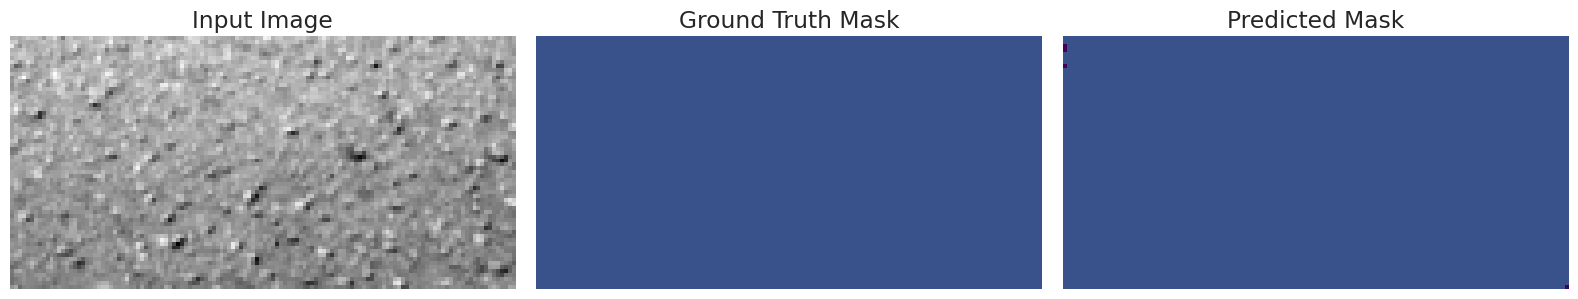

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 475ms/step - class1: 0.8074 - class2: 0.6513 - class3: 0.6809 - class4: 0.1704 - loss: 0.4536 - mean_iou: 0.5273 - val_class1: 0.6673 - val_class2: 0.4680 - val_class3: 0.6317 - val_class4: 0.0177 - val_loss: 0.7134 - val_mean_iou: 0.4125
Epoch 32/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - class1: 0.8048 - class2: 0.6521 - class3: 0.6680 - class4: 0.1854 - loss: 0.4629 - mean_iou: 0.5285 - val_class1: 0.6999 - val_class2: 0.5281 - val_class3: 0.6604 - val_class4: 0.0000e+00 - val_loss: 0.6268 - val_mean_iou: 0.4328
Epoch 33/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 428ms/step - class1: 0.7993 - class2: 0.6457 - class3: 0.6547 - class4: 0.1865 - loss: 0.4730 - mean_iou: 0.5237 - val_class1: 0.6669 - val_class2: 0.4895 - val_class3: 0.6212 - val_class4: 0.0000e+00 - val_loss: 0.6634 - val_mean_iou: 0.4078
Epoch 34/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 430ms/step - class1: 0.8060 - class2: 0.6519 - class3: 0.6681 - class4: 0.1769 - loss: 0.4632 - mean_iou: 0.5274 

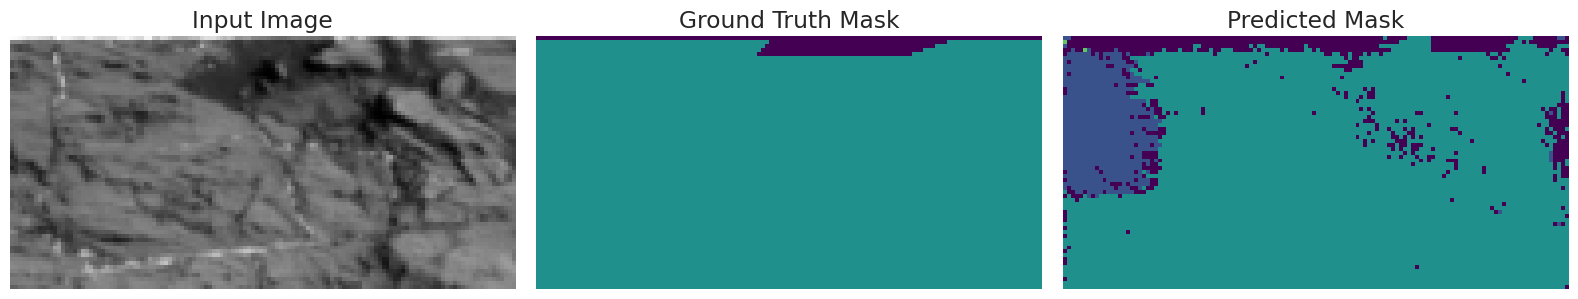

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 491ms/step - class1: 0.8081 - class2: 0.6449 - class3: 0.6712 - class4: 0.1789 - loss: 0.4635 - mean_iou: 0.5259 - val_class1: 0.6495 - val_class2: 0.5122 - val_class3: 0.6351 - val_class4: 0.0000e+00 - val_loss: 0.6805 - val_mean_iou: 0.4154
Epoch 37/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 435ms/step - class1: 0.8111 - class2: 0.6521 - class3: 0.6706 - class4: 0.2053 - loss: 0.4603 - mean_iou: 0.5361 - val_class1: 0.6745 - val_class2: 0.5233 - val_class3: 0.6124 - val_class4: 0.0024 - val_loss: 0.6899 - val_mean_iou: 0.4172
Epoch 38/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step - class1: 0.8059 - class2: 0.6508 - class3: 0.6573 - class4: 0.1867 - loss: 0.4638 - mean_iou: 0.5278 - val_class1: 0.6752 - val_class2: 0.4805 - val_class3: 0.6514 - val_class4: 0.0144 - val_loss: 0.6888 - val_mean_iou: 0.4229
Epoch 39/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 428ms/step - class1: 0.8067 - class2: 0.6488 - class3: 0.6659 - class4: 0.1926 - loss: 0.4582 - mean_iou: 0.5304 - va

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 483ms/step - class1: 0.8090 - class2: 0.6494 - class3: 0.6642 - class4: 0.2249 - loss: 0.4554 - mean_iou: 0.5368 - val_class1: 0.6741 - val_class2: 0.5167 - val_class3: 0.6091 - val_class4: 0.0154 - val_loss: 0.6825 - val_mean_iou: 0.4087
Epoch 42/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - class1: 0.8166 - class2: 0.6595 - class3: 0.6811 - class4: 0.2089 - loss: 0.4425 - mean_iou: 0.5404 - val_class1: 0.6997 - val_class2: 0.4823 - val_class3: 0.6457 - val_class4: 0.0000e+00 - val_loss: 0.6685 - val_mean_iou: 0.4142
Epoch 43/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 428ms/step - class1: 0.8106 - class2: 0.6465 - class3: 0.6637 - class4: 0.1671 - loss: 0.4700 - mean_iou: 0.5245 - val_class1: 0.6552 - val_class2: 0.4540 - val_class3: 0.5427 - val_class4: 0.0021 - val_loss: 0.7235 - val_mean_iou: 0.3864
Epoch 44/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 434ms/step - class1: 0.8093 - class2: 0.6506 - class3: 0.6648 - class4: 0.1842 - loss: 0.4598 - mean_iou: 0.5288 - va

In [34]:
# Train the model
with strategy.scope():
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, viz_callback],
        verbose=1,
        #class_weight=class_weights
    ).history
    
    # Calculate and print the final validation accuracy
    final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

La classe 4 è presente in 7 immagini.
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step
Img 24


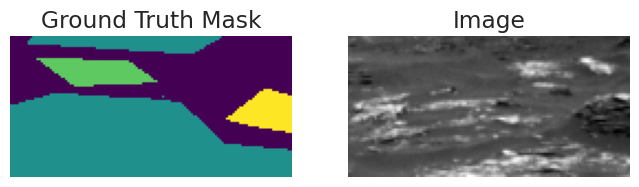

Img 202


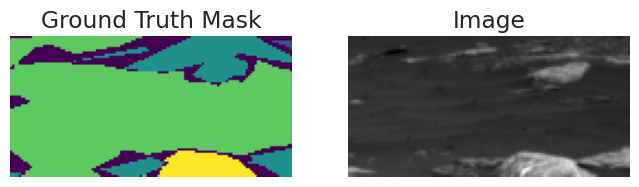

Img 229


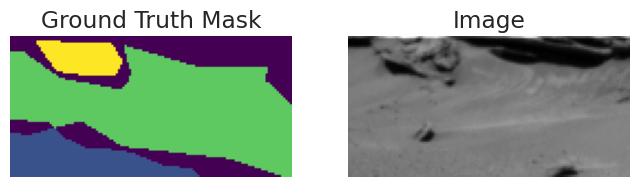

Img 365


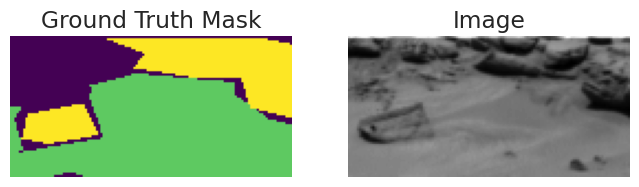

Img 464


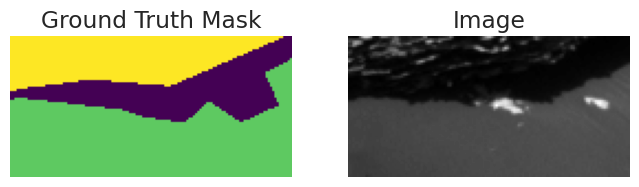

Img 489


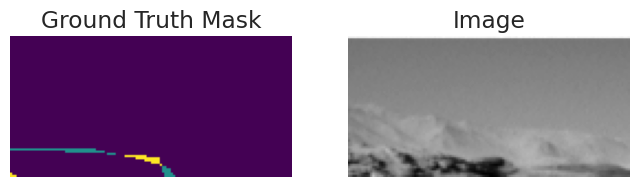

Img 493


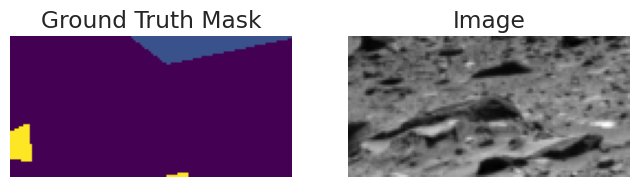

In [35]:
target_class = 4
num_images_with_class = sum(target_class in np.unique(y) for y in y_val)
print(f"La classe {target_class} è presente in {num_images_with_class} immagini.")


# Trova gli indici delle immagini che contengono la classe target
indices_with_class = [idx for idx, y in enumerate(y_val) if target_class in np.unique(y)]

preds= tf.math.argmax(model.predict(X_val), axis=-1)

for idx in indices_with_class:
    plt.figure(figsize=(8, 4))
    
    print("Img " + str(idx))
    
    # Immagine originale
    plt.subplot(1, 2, 1)
    colormap = plt.cm.viridis(np.linspace(0, 1, 5))
    colored_label = apply_colormap(y_val[idx], colormap)
    plt.imshow(colored_label)
    plt.title("Ground Truth Mask")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    colormap = plt.cm.viridis(np.linspace(0, 1, 5))
    colored_label = apply_colormap(preds[idx], colormap)
    plt.imshow(X_val[idx], cmap="gray")
    plt.title("Image")
    plt.axis('off')
    
    plt.show()


In [36]:
y_pred = model.predict(X_val)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


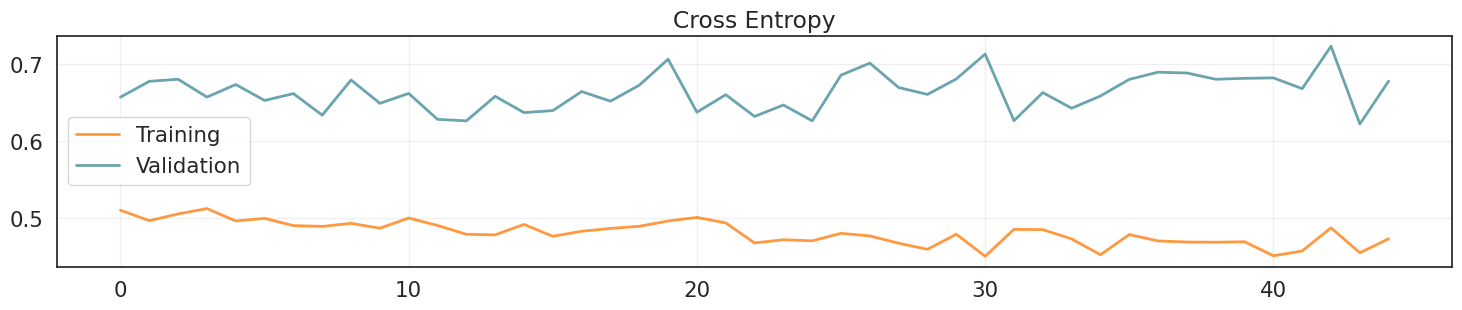

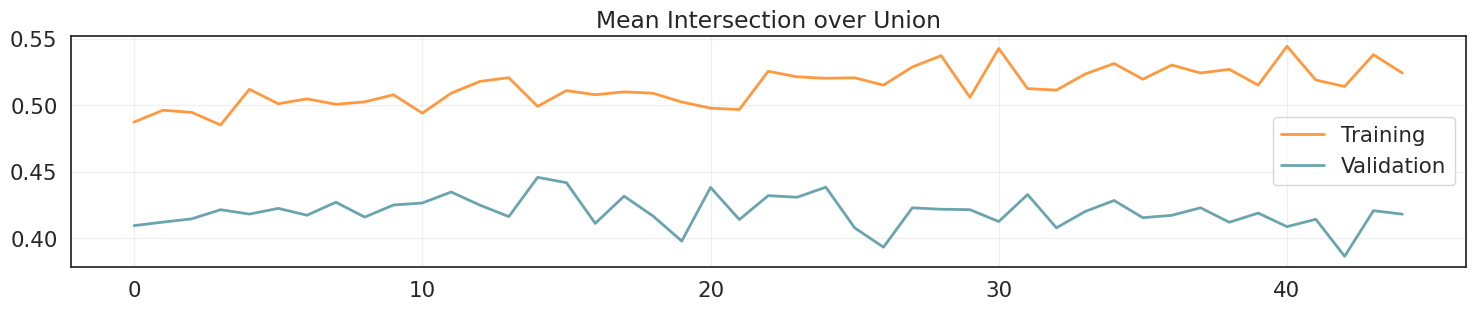

In [37]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [44]:
model.evaluate(test_dataset)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - class1: 0.6571 - class2: 0.5301 - class3: 0.5091 - class4: 0.0011 - loss: nan - mean_iou: 0.3885   


[0.7540220022201538,
 0.3759184777736664,
 0.6456296443939209,
 0.47272810339927673,
 0.5046195983886719,
 0.0006702412501908839]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_data, class_names):
    """
    Plots the confusion matrix for the given model and test data.
    
    Args:
        model: Trained Keras model.
        test_data: A `tf.data.Dataset` or similar iterable with (inputs, labels).
        class_names: List of class names corresponding to the labels.
    """
    # Get ground-truth labels and model predictions
    y_true = []
    y_pred = []
    
    for inputs, labels in test_data:
        predictions = model.predict(inputs)
        y_true.extend(np.argmax(labels.numpy(), axis=-1))
        y_pred.extend(np.argmax(predictions, axis=-1))

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, test_dataset, [0, 1, 2, 3, 4])

In [45]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step
Predictions shape: (10022, 64, 128)


In [46]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [47]:
from time import time

# Create and download the csv submission file
timestep_str = int(time())
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)